# Customer Churn Prediction - End-to-End ML Pipeline

This notebook implements a complete machine learning pipeline for predicting customer churn using scikit-learn's Pipeline API.

## Objectives:
- Build reusable preprocessing pipelines
- Train and compare Logistic Regression and Random Forest models
- Perform hyperparameter tuning with GridSearchCV
- Export the complete pipeline for production use
- Evaluate model performance comprehensively

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random state for reproducibility
RANDOM_STATE = 42

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading and Exploration

In [3]:
# Load the dataset
df = pd.read_csv('dataset/customer_churn_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nDataset info:")
print(df.info())
print(f"\nFirst 5 rows:")
df.head()

Dataset shape: (50000, 7)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tenure_months           50000 non-null  int64  
 1   monthly_usage_hours     50000 non-null  float64
 2   has_multiple_devices    50000 non-null  int64  
 3   customer_support_calls  50000 non-null  int64  
 4   payment_failures        50000 non-null  int64  
 5   is_premium_plan         50000 non-null  int64  
 6   churn                   50000 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 2.7 MB
None

First 5 rows:


,tenure_months,monthly_usage_hours,has_multiple_devices,customer_support_calls,payment_failures,is_premium_plan,churn
0,39,30.953928,0,1,0,0,0
1,52,20.485203,0,0,0,0,0
2,29,21.684462,0,1,1,0,0
3,15,27.894281,0,1,0,1,0
4,43,19.250190,1,1,0,0,0


In [4]:
# Basic statistics
print("Dataset Statistics:")
print(df.describe())

print(f"\nMissing values:")
print(df.isnull().sum())

print(f"\nTarget variable distribution:")
print(df['churn'].value_counts())
print(f"\nChurn rate: {df['churn'].mean():.3f}")

Dataset Statistics:
       tenure_months  monthly_usage_hours  has_multiple_devices  \
count   50000.000000         50000.000000           50000.00000   
mean       30.029760            20.000411               0.39882   
std        16.997771             4.996693               0.48966   
min         1.000000             0.000000               0.00000   
25%        15.000000            16.589750               0.00000   
50%        30.000000            20.026256               0.00000   
75%        45.000000            23.387508               1.00000   
max        59.000000            38.726896               1.00000   

       customer_support_calls  payment_failures  is_premium_plan         churn  
count            50000.000000      50000.000000     50000.000000  50000.000000  
mean                 1.205680          0.098780         0.298340      0.020660  
std                  1.101236          0.298369         0.457534      0.142245  
min                  0.000000          0.000000     

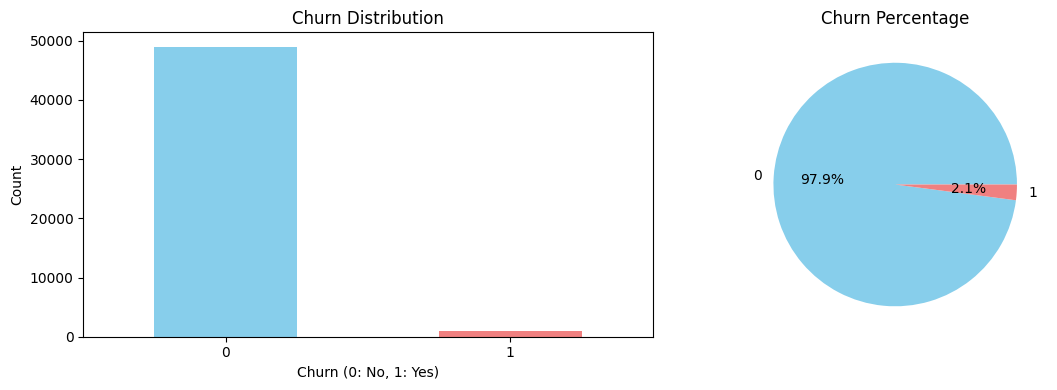

In [5]:
# Visualize target distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
df['churn'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Churn Distribution')
plt.xlabel('Churn (0: No, 1: Yes)')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
df['churn'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Churn Percentage')
plt.ylabel('')

plt.tight_layout()
plt.show()

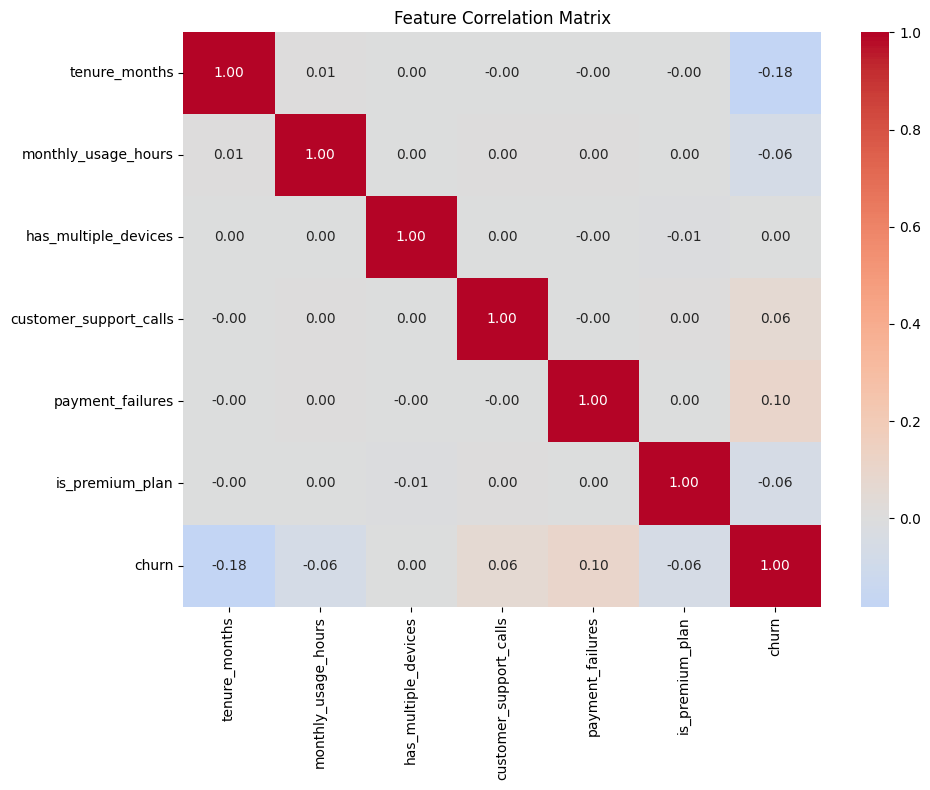

Correlation with target variable 'churn':
churn                     1.000000
payment_failures          0.102242
customer_support_calls    0.060077
has_multiple_devices      0.001728
is_premium_plan          -0.059675
monthly_usage_hours      -0.063565
tenure_months            -0.181461
Name: churn, dtype: float64


In [6]:
# Feature correlation analysis
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

print("Correlation with target variable 'churn':")
print(correlation_matrix['churn'].sort_values(ascending=False))

## 2. Data Preprocessing Pipeline

In [7]:
# Separate features and target
X = df.drop('churn', axis=1)
y = df['churn']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {list(X.columns)}")

Features shape: (50000, 6)
Target shape: (50000,)

Feature columns: ['tenure_months', 'monthly_usage_hours', 'has_multiple_devices', 'customer_support_calls', 'payment_failures', 'is_premium_plan']


In [8]:
# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

# All features are numerical in this dataset
print(f"\nAll features are numerical: {len(categorical_features) == 0}")

Numerical features: ['tenure_months', 'monthly_usage_hours', 'has_multiple_devices', 'customer_support_calls', 'payment_failures', 'is_premium_plan']
Categorical features: []

All features are numerical: True


In [9]:
# Create preprocessing pipeline
# Since all features are numerical, we only need scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ]
)

print("Preprocessing pipeline created successfully!")
print("Pipeline steps:")
print("1. StandardScaler for numerical features")

Preprocessing pipeline created successfully!
Pipeline steps:
1. StandardScaler for numerical features


In [10]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nTraining set churn rate: {y_train.mean():.3f}")
print(f"Test set churn rate: {y_test.mean():.3f}")

Training set shape: (40000, 6)
Test set shape: (10000, 6)

Training set churn rate: 0.021
Test set churn rate: 0.021


## 3. Model Training and Pipeline Creation

In [11]:
# Create pipelines for different models
# Logistic Regression Pipeline
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=RANDOM_STATE))
])

# Random Forest Pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

print("Model pipelines created successfully!")
print("\nLogistic Regression Pipeline:")
print(lr_pipeline)
print("\nRandom Forest Pipeline:")
print(rf_pipeline)

Model pipelines created successfully!

Logistic Regression Pipeline:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['tenure_months',
                                                   'monthly_usage_hours',
                                                   'has_multiple_devices',
                                                   'customer_support_calls',
                                                   'payment_failures',
                                                   'is_premium_plan'])])),
                ('classifier', LogisticRegression(random_state=42))])

Random Forest Pipeline:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['tenure_months',
                                                   'monthly_usage_hours',
                                      

In [12]:
# Train initial models for baseline performance
print("Training baseline models...")

# Train Logistic Regression
lr_pipeline.fit(X_train, y_train)
lr_train_score = lr_pipeline.score(X_train, y_train)
lr_test_score = lr_pipeline.score(X_test, y_test)

print(f"Logistic Regression - Train Accuracy: {lr_train_score:.4f}")
print(f"Logistic Regression - Test Accuracy: {lr_test_score:.4f}")

# Train Random Forest
rf_pipeline.fit(X_train, y_train)
rf_train_score = rf_pipeline.score(X_train, y_train)
rf_test_score = rf_pipeline.score(X_test, y_test)

print(f"Random Forest - Train Accuracy: {rf_train_score:.4f}")
print(f"Random Forest - Test Accuracy: {rf_test_score:.4f}")

Training baseline models...
Logistic Regression - Train Accuracy: 0.9800
Logistic Regression - Test Accuracy: 0.9796
Random Forest - Train Accuracy: 1.0000
Random Forest - Test Accuracy: 0.9788


## 4. Hyperparameter Tuning with GridSearchCV

In [13]:
# Define parameter grids for hyperparameter tuning
lr_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'lbfgs'],
    'classifier__max_iter': [1000, 2000]
}

rf_param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

print("Parameter grids defined:")
print(f"Logistic Regression parameters: {len(lr_param_grid)} hyperparameters")
print(f"Random Forest parameters: {len(rf_param_grid)} hyperparameters")

Parameter grids defined:
Logistic Regression parameters: 3 hyperparameters
Random Forest parameters: 4 hyperparameters


In [14]:
# GridSearchCV for Logistic Regression
print("Performing GridSearchCV for Logistic Regression...")
lr_grid_search = GridSearchCV(
    lr_pipeline, 
    lr_param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

lr_grid_search.fit(X_train, y_train)

print(f"Best Logistic Regression parameters: {lr_grid_search.best_params_}")
print(f"Best Logistic Regression CV score: {lr_grid_search.best_score_:.4f}")

Performing GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Logistic Regression parameters: {'classifier__C': 10, 'classifier__max_iter': 1000, 'classifier__solver': 'liblinear'}
Best Logistic Regression CV score: 0.9799


In [15]:
# GridSearchCV for Random Forest (with reduced grid for efficiency)
print("Performing GridSearchCV for Random Forest...")
rf_param_grid_reduced = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [10, 15, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

rf_grid_search = GridSearchCV(
    rf_pipeline, 
    rf_param_grid_reduced, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

rf_grid_search.fit(X_train, y_train)

print(f"Best Random Forest parameters: {rf_grid_search.best_params_}")
print(f"Best Random Forest CV score: {rf_grid_search.best_score_:.4f}")

Performing GridSearchCV for Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Random Forest parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Best Random Forest CV score: 0.9840


## 5. Model Evaluation and Comparison

In [16]:
# Get best models
best_lr_model = lr_grid_search.best_estimator_
best_rf_model = rf_grid_search.best_estimator_

# Make predictions
lr_predictions = best_lr_model.predict(X_test)
rf_predictions = best_rf_model.predict(X_test)

lr_predictions_proba = best_lr_model.predict_proba(X_test)[:, 1]
rf_predictions_proba = best_rf_model.predict_proba(X_test)[:, 1]

print("Predictions generated for both models.")

Predictions generated for both models.


In [17]:
# Comprehensive evaluation function
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    """
    Comprehensive model evaluation with multiple metrics
    """
    print(f"\n=== {model_name} Evaluation ===")
    
    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred_proba)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_score:.4f}")
    
    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_score
    }

# Evaluate both models
lr_metrics = evaluate_model(y_test, lr_predictions, lr_predictions_proba, "Logistic Regression")
rf_metrics = evaluate_model(y_test, rf_predictions, rf_predictions_proba, "Random Forest")


=== Logistic Regression Evaluation ===
Accuracy: 0.9797
Precision: 0.6111
Recall: 0.0531
F1-Score: 0.0978
AUC-ROC: 0.9052

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9793
           1       0.61      0.05      0.10       207

    accuracy                           0.98     10000
   macro avg       0.80      0.53      0.54     10000
weighted avg       0.97      0.98      0.97     10000


=== Random Forest Evaluation ===
Accuracy: 0.9838
Precision: 0.6829
Recall: 0.4058
F1-Score: 0.5091
AUC-ROC: 0.9742

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9793
           1       0.68      0.41      0.51       207

    accuracy                           0.98     10000
   macro avg       0.84      0.70      0.75     10000
weighted avg       0.98      0.98      0.98     10000



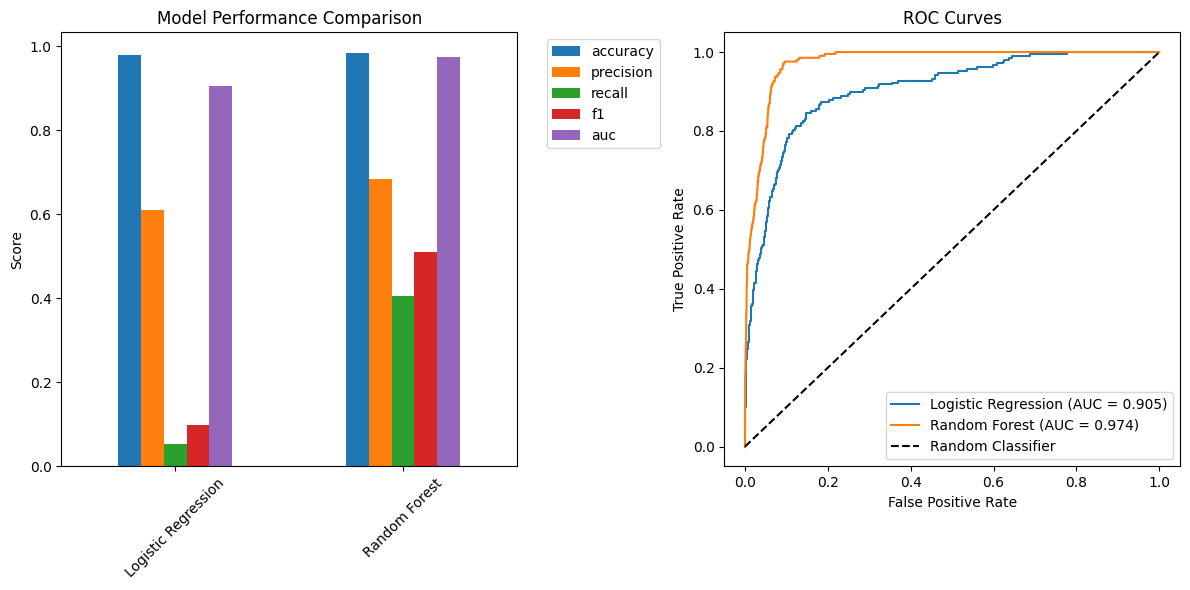

In [18]:
# Visualize model comparison
metrics_df = pd.DataFrame({
    'Logistic Regression': lr_metrics,
    'Random Forest': rf_metrics
})

plt.figure(figsize=(12, 6))

# Metrics comparison
plt.subplot(1, 2, 1)
metrics_df.T.plot(kind='bar', ax=plt.gca())
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# ROC Curves
plt.subplot(1, 2, 2)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_predictions_proba)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_predictions_proba)

plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_metrics["auc"]:.3f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_metrics["auc"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()

plt.tight_layout()
plt.show()

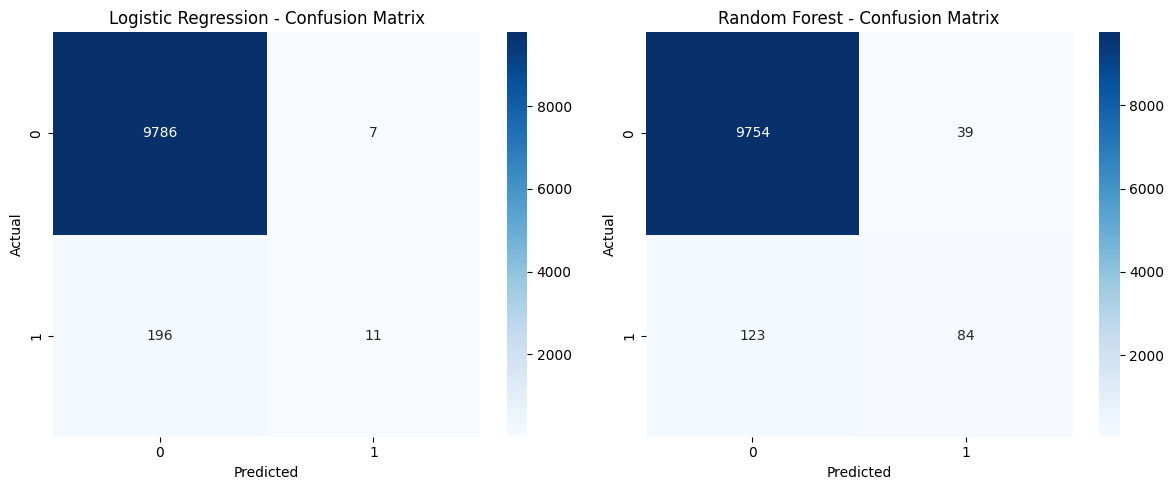

In [19]:
# Confusion matrices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm_lr = confusion_matrix(y_test, lr_predictions)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.subplot(1, 2, 2)
cm_rf = confusion_matrix(y_test, rf_predictions)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.tight_layout()
plt.show()

## 6. Feature Importance Analysis

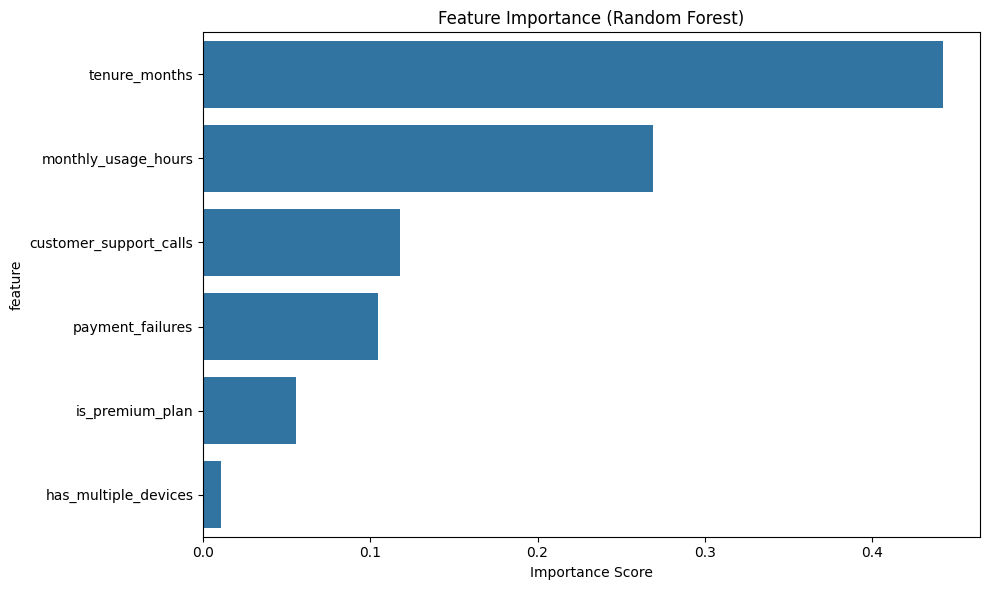

Feature Importance Ranking:
                  feature  importance
0           tenure_months    0.442423
1     monthly_usage_hours    0.269177
3  customer_support_calls    0.117525
4        payment_failures    0.104552
5         is_premium_plan    0.055300
2    has_multiple_devices    0.011024


In [20]:
# Feature importance for Random Forest
rf_classifier = best_rf_model.named_steps['classifier']
feature_importance = rf_classifier.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='importance', y='feature')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

print("Feature Importance Ranking:")
print(importance_df)

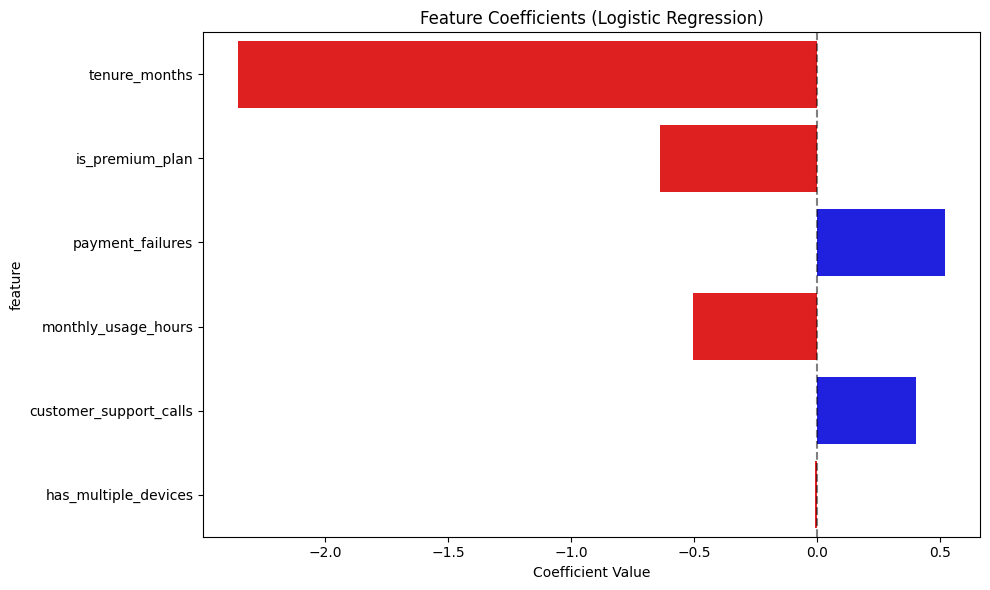

Feature Coefficients (Logistic Regression):
                  feature  coefficient
0           tenure_months    -2.352157
5         is_premium_plan    -0.638332
4        payment_failures     0.517190
1     monthly_usage_hours    -0.506768
3  customer_support_calls     0.399136
2    has_multiple_devices    -0.008050


In [21]:
# Logistic Regression coefficients
lr_classifier = best_lr_model.named_steps['classifier']
coefficients = lr_classifier.coef_[0]

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=False)

plt.figure(figsize=(10, 6))
colors = ['red' if x < 0 else 'blue' for x in coef_df['coefficient']]
sns.barplot(data=coef_df, x='coefficient', y='feature', palette=colors)
plt.title('Feature Coefficients (Logistic Regression)')
plt.xlabel('Coefficient Value')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("Feature Coefficients (Logistic Regression):")
print(coef_df[['feature', 'coefficient']])

## 7. Model Selection and Pipeline Export

In [22]:
# Select best model based on AUC score
if rf_metrics['auc'] > lr_metrics['auc']:
    best_model = best_rf_model
    best_model_name = "Random Forest"
    best_metrics = rf_metrics
else:
    best_model = best_lr_model
    best_model_name = "Logistic Regression"
    best_metrics = lr_metrics

print(f"Best Model Selected: {best_model_name}")
print(f"Best Model AUC Score: {best_metrics['auc']:.4f}")
print(f"\nBest Model Performance:")
for metric, value in best_metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")

Best Model Selected: Random Forest
Best Model AUC Score: 0.9742

Best Model Performance:
Accuracy: 0.9838
Precision: 0.6829
Recall: 0.4058
F1: 0.5091
Auc: 0.9742


In [23]:
# Export the complete pipeline using joblib
print("Exporting the best model pipeline...")

# Save the best model
joblib.dump(best_model, 'best_churn_model_pipeline.pkl')

# Save additional information
model_info = {
    'model_name': best_model_name,
    'model_type': type(best_model.named_steps['classifier']).__name__,
    'metrics': best_metrics,
    'feature_names': list(X.columns),
    'target_name': 'churn',
    'preprocessing_steps': str(best_model.named_steps['preprocessor']),
    'best_parameters': best_rf_model.named_steps['classifier'].get_params() if best_model_name == 'Random Forest' else best_lr_model.named_steps['classifier'].get_params()
}

joblib.dump(model_info, 'model_info.pkl')

print("Model pipeline exported successfully!")
print("Files saved:")
print("- best_churn_model_pipeline.pkl")
print("- model_info.pkl")

Exporting the best model pipeline...
Model pipeline exported successfully!
Files saved:
- best_churn_model_pipeline.pkl
- model_info.pkl


In [24]:
# Calculate validation rules from training data
validation_rules = {
    'feature_rules': {
        'tenure_months': {
            'dtype': 'int64',
            'min': int(X['tenure_months'].min()),
            'max': int(X['tenure_months'].max()),
            'description': 'Number of months the customer has been with the service'
        },
        'monthly_usage_hours': {
            'dtype': 'float64',
            'min': float(X['monthly_usage_hours'].min()),
            'max': float(X['monthly_usage_hours'].max()),
            'description': 'Average monthly usage hours'
        },
        'has_multiple_devices': {
            'dtype': 'int64',
            'allowed_values': [0, 1],
            'description': 'Whether the customer uses multiple devices (0=No, 1=Yes)'
        },
        'customer_support_calls': {
            'dtype': 'int64',
            'min': int(X['customer_support_calls'].min()),
            'max': int(X['customer_support_calls'].max()),
            'description': 'Number of customer support calls made'
        },
        'payment_failures': {
            'dtype': 'int64',
            'min': int(X['payment_failures'].min()),
            'max': int(X['payment_failures'].max()),
            'description': 'Number of payment failures'
        },
        'is_premium_plan': {
            'dtype': 'int64',
            'allowed_values': [0, 1],
            'description': 'Whether the customer is on a premium plan (0=No, 1=Yes)'
        }
    },
    'target_variable': {
        'name': 'churn',
        'dtype': 'int64',
        'allowed_values': [0, 1],
        'description': 'Whether the customer churned (0=No, 1=Yes)'
    },
    'created_at': pd.Timestamp.now().isoformat(),
    'dataset_statistics': {
        'num_samples': len(X),
        'num_features': len(X.columns),
        'class_distribution': y.value_counts().to_dict()
    }
}

# Update model_info with validation rules
model_info['validation_rules'] = validation_rules

In [25]:
# Test the saved model
print("Testing the saved model...")

# Load the saved model
loaded_model = joblib.load('best_churn_model_pipeline.pkl')
loaded_info = joblib.load('model_info.pkl')

# Make predictions with loaded model
test_predictions = loaded_model.predict(X_test[:5])
test_probabilities = loaded_model.predict_proba(X_test[:5])

print("Sample predictions from loaded model:")
for i in range(5):
    print(f"Sample {i+1}: Prediction = {test_predictions[i]}, Probability = {test_probabilities[i][1]:.3f}")

print(f"\nLoaded model info:")
print(f"Model name: {loaded_info['model_name']}")
print(f"Model type: {loaded_info['model_type']}")
print(f"Test AUC: {loaded_info['metrics']['auc']:.4f}")

Testing the saved model...
Sample predictions from loaded model:
Sample 1: Prediction = 0, Probability = 0.000
Sample 2: Prediction = 0, Probability = 0.000
Sample 3: Prediction = 0, Probability = 0.000
Sample 4: Prediction = 0, Probability = 0.000
Sample 5: Prediction = 0, Probability = 0.000

Loaded model info:
Model name: Random Forest
Model type: RandomForestClassifier
Test AUC: 0.9742


## 8. Summary and Insights

In [26]:
print("=== CUSTOMER CHURN PREDICTION - FINAL SUMMARY ===")
print(f"\nDataset: {df.shape[0]:,} customers with {df.shape[1]-1} features")
print(f"Churn Rate: {df['churn'].mean():.1%}")

print(f"\n=== MODEL PERFORMANCE ===")
print(f"Best Model: {best_model_name}")
print(f"Accuracy: {best_metrics['accuracy']:.3f}")
print(f"Precision: {best_metrics['precision']:.3f}")
print(f"Recall: {best_metrics['recall']:.3f}")
print(f"F1-Score: {best_metrics['f1']:.3f}")
print(f"AUC-ROC: {best_metrics['auc']:.3f}")

print(f"\n=== KEY INSIGHTS ===")
if best_model_name == "Random Forest":
    top_features = importance_df.head(3)['feature'].tolist()
    print(f"Top 3 Most Important Features: {', '.join(top_features)}")
else:
    top_features = coef_df.head(3)['feature'].tolist()
    print(f"Top 3 Most Influential Features: {', '.join(top_features)}")

print(f"\n=== DEPLOYMENT READY ===")
print("✓ Complete preprocessing pipeline exported")
print("✓ Best model with hyperparameter tuning saved")
print("✓ Model ready for production deployment")
print("✓ Pipeline can be loaded and used for new predictions")

print(f"\n=== NEXT STEPS ===")
print("1. Deploy model using Streamlit application")
print("2. Monitor model performance in production")
print("3. Retrain model periodically with new data")
print("4. Consider feature engineering for improvement")

=== CUSTOMER CHURN PREDICTION - FINAL SUMMARY ===

Dataset: 50,000 customers with 6 features
Churn Rate: 2.1%

=== MODEL PERFORMANCE ===
Best Model: Random Forest
Accuracy: 0.984
Precision: 0.683
Recall: 0.406
F1-Score: 0.509
AUC-ROC: 0.974

=== KEY INSIGHTS ===
Top 3 Most Important Features: tenure_months, monthly_usage_hours, customer_support_calls

=== DEPLOYMENT READY ===
✓ Complete preprocessing pipeline exported
✓ Best model with hyperparameter tuning saved
✓ Model ready for production deployment
✓ Pipeline can be loaded and used for new predictions

=== NEXT STEPS ===
1. Deploy model using Streamlit application
2. Monitor model performance in production
3. Retrain model periodically with new data
4. Consider feature engineering for improvement
